In [1]:
%load_ext autoreload
%autoreload 2

### MCMC

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from mixedbridge.stochastic_processes.examples import CellDiffusionProcess, CellDiffusionAuxProcess
from mixedbridge.stochastic_processes.gbp import GuidedBridgeProcess
from mixedbridge.baselines.pcn import PreconditionedCrankNicolson
from mixedbridge.solvers.sde import Euler, WienerProcess

In [2]:
dim = 2
T = 4.0
dt = 1. / 100
dtype = jnp.float32

alpha = 1. / 16.
sigma = 0.1

rng_key = jax.random.PRNGKey(42)
x0 = jnp.array([0.1, -0.1], dtype=dtype)
v  = jnp.array([2.0, -0.1], dtype=dtype)

In [3]:
t_scheme = "linear"
ode_solver_kernel = "dopri5"

wiener_proc    = WienerProcess(T=T, dt=dt, dim=dim, t_scheme=t_scheme, dtype=dtype)
ori_proc       = CellDiffusionProcess(alpha=alpha, sigma=sigma, T=T, dim=dim, dtype=dtype)
aux_proc       = CellDiffusionAuxProcess(alpha=alpha, sigma=sigma, T=T, dim=dim, dtype=dtype)

guided_proc = GuidedBridgeProcess(
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    x0=x0,
    v=v,
    L0=jnp.eye(dim, dtype=dtype), 
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10, 
    ts=wiener_proc.ts,
    ode_solver_kernel=ode_solver_kernel
)

ori_solver           = Euler(sde=ori_proc, wiener=wiener_proc)
aux_solver           = Euler(sde=aux_proc, wiener=wiener_proc)
guided_bridge_solver = Euler(sde=guided_proc, wiener=wiener_proc)

In [4]:
n_samples = 32
ori_path = ori_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)
aux_path = aux_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)
guided_bridge_path = guided_bridge_solver.solve(x0=x0, dWs=None, rng_key=rng_key, n_batches=n_samples)

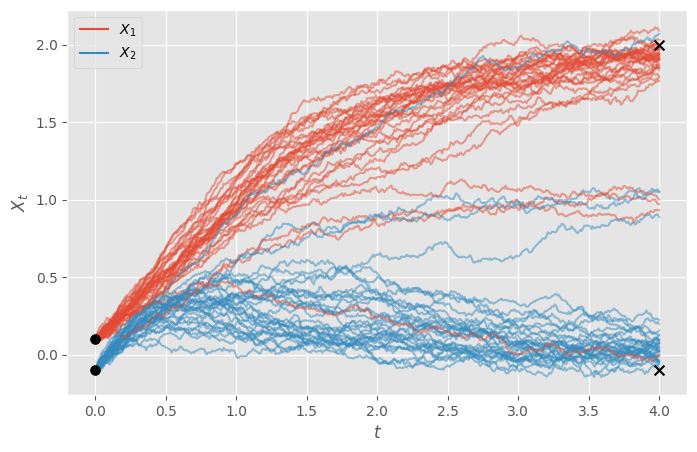

In [5]:
plt.figure(figsize=(8, 5))
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_1 = color_cycle[0]
color_2 = color_cycle[1]
for i in range(n_samples):
    plt.plot(ori_path.ts, ori_path.xs[i, :, 0], color=color_1, alpha=0.5)
    plt.plot(ori_path.ts, ori_path.xs[i, :, 1], color=color_2, alpha=0.5)
plt.plot([], [], color=color_1, alpha=1.0, label=r'$X_1$')
plt.plot([], [], color=color_2, alpha=1.0, label=r'$X_2$')
plt.scatter(0.0, x0[0], color="black", marker='o', s=50, zorder=10)
plt.scatter(0.0, x0[1], color="black", marker='o', s=50, zorder=10)
plt.scatter(T, v[0], color="black", marker='x', s=50, zorder=10)
plt.scatter(T, v[1], color="black", marker='x', s=50, zorder=10)
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$X_t$')
plt.show()

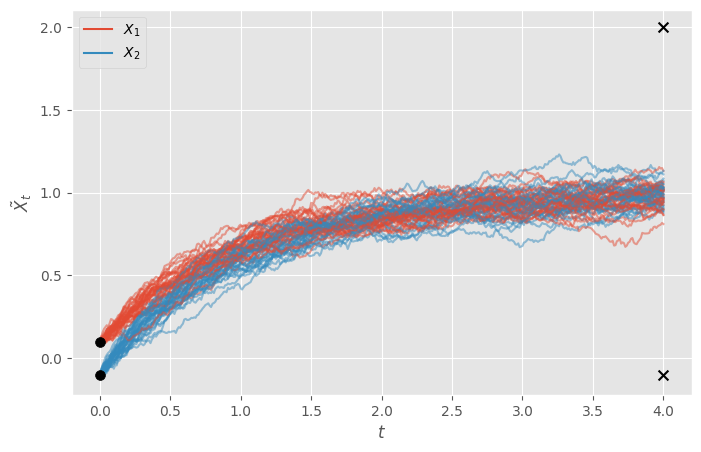

In [6]:
plt.figure(figsize=(8, 5))
for i in range(n_samples):
    plt.plot(aux_path.ts, aux_path.xs[i, :, 0], color=color_1, alpha=0.5)
    plt.plot(aux_path.ts, aux_path.xs[i, :, 1], color=color_2, alpha=0.5)
plt.plot([], [], color=color_1, alpha=1.0, label=r'$X_1$')
plt.plot([], [], color=color_2, alpha=1.0, label=r'$X_2$')
plt.scatter(0.0, x0[0], color="black", marker='o', s=50, zorder=10)
plt.scatter(0.0, x0[1], color="black", marker='o', s=50, zorder=10)
plt.scatter(T, v[0], color="black", marker='x', s=50, zorder=10)
plt.scatter(T, v[1], color="black", marker='x', s=50, zorder=10)
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$\tilde{X}_t$')
plt.show()

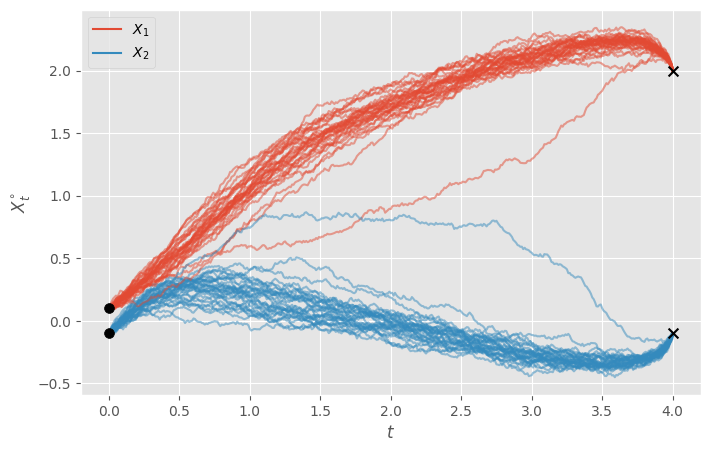

In [7]:
plt.figure(figsize=(8, 5))
for i in range(n_samples):
    plt.plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 0], color=color_1, alpha=0.5)
    plt.plot(guided_bridge_path.ts, guided_bridge_path.xs[i, :, 1], color=color_2, alpha=0.5)
plt.plot([], [], color=color_1, alpha=1.0, label=r'$X_1$')
plt.plot([], [], color=color_2, alpha=1.0, label=r'$X_2$')
plt.scatter(0.0, x0[0], color="black", marker='o', s=50, zorder=10)
plt.scatter(0.0, x0[1], color="black", marker='o', s=50, zorder=10)
plt.scatter(T, v[0], color="black", marker='x', s=50, zorder=10)
plt.scatter(T, v[1], color="black", marker='x', s=50, zorder=10)
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$X^{\circ}_t$')
plt.show()

In [8]:
mcmc_model = PreconditionedCrankNicolson(
    x0=x0,
    v=v,
    ori_proc=ori_proc,
    aux_proc=aux_proc,
    wiener=wiener_proc,
    rho=0.98,
    L0=jnp.eye(dim, dtype=dtype),
    Sigma0=jnp.eye(dim, dtype=dtype)*1e-10,
    rng_key=jax.random.PRNGKey(42),
    n_batches=n_samples
)
mcmc_path, mcmc_lls = mcmc_model.run(n_iters=20000, verbose=True, log_every=1000)

Iteration 1/20000: log likelihood = 137.99057006835938
Iteration 1001/20000: log likelihood = 283.13055419921875
Iteration 2001/20000: log likelihood = 292.06097412109375
Iteration 3001/20000: log likelihood = 309.3009948730469
Iteration 4001/20000: log likelihood = 278.6964111328125
Iteration 5001/20000: log likelihood = 287.2496032714844
Iteration 6001/20000: log likelihood = 311.4614562988281
Iteration 7001/20000: log likelihood = 295.0060729980469
Iteration 8001/20000: log likelihood = 314.7042541503906
Iteration 9001/20000: log likelihood = 284.0435485839844
Iteration 10001/20000: log likelihood = 303.4865417480469
Iteration 11001/20000: log likelihood = 275.5171203613281
Iteration 12001/20000: log likelihood = 273.6372375488281
Iteration 13001/20000: log likelihood = 292.4774169921875
Iteration 14001/20000: log likelihood = 315.4198303222656
Iteration 15001/20000: log likelihood = 297.08563232421875
Iteration 16001/20000: log likelihood = 310.012939453125
Iteration 17001/20000: l

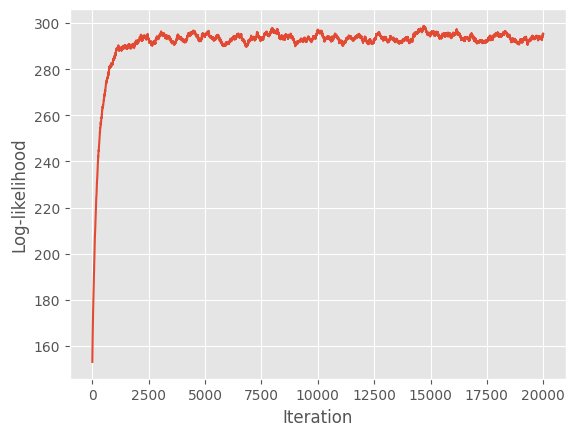

In [9]:
avg_lls = jnp.mean(mcmc_lls, axis=-1)
plt.plot(avg_lls)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.show()

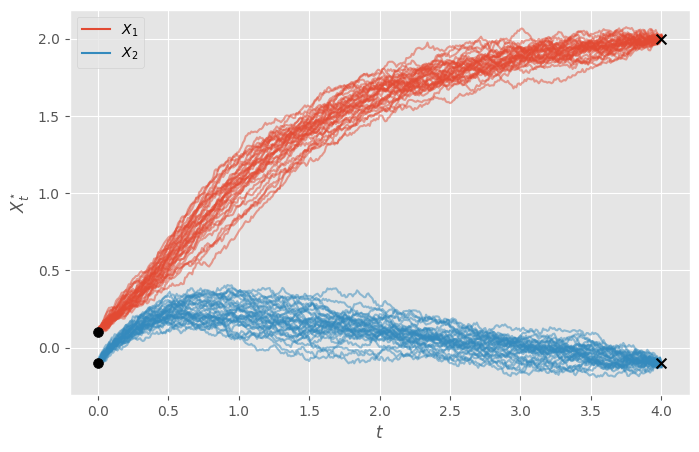

In [10]:
plt.figure(figsize=(8, 5))
for i in range(n_samples):
    plt.plot(mcmc_path.ts, mcmc_path.xs[i, :, 0], color=color_1, alpha=0.5)
    plt.plot(mcmc_path.ts, mcmc_path.xs[i, :, 1], color=color_2, alpha=0.5)
plt.plot([], [], color=color_1, alpha=1.0, label=r'$X_1$')
plt.plot([], [], color=color_2, alpha=1.0, label=r'$X_2$')
plt.scatter(0.0, x0[0], color="black", marker='o', s=50, zorder=10)
plt.scatter(0.0, x0[1], color="black", marker='o', s=50, zorder=10)
plt.scatter(T, v[0], color="black", marker='x', s=50, zorder=10)
plt.scatter(T, v[1], color="black", marker='x', s=50, zorder=10)
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel(r'$X^{\star}_t$')
plt.show()

### Score matching

In [ ]:
from mixedbridge.baselines.sm import ScoreMatchingReverseBridge, ScoreMatchingForwardBridge
from mixedbridge.networks.score_net import ScoreNetSmall

In [11]:
sm_model = ScoreMatchingReverseBridge(
    x0=x0,
    xT=xT,
    proc=cell_proc,
    model=ScoreNetSmall(out_dim=dim, hidden_dims=[20, 20, 20, 20]),
    rng_key=jax.random.PRNGKey(42),
    n_batches=32,
    lr=1e-3
)

In [15]:
sm_path, reverse_bridge = sm_model.run(n_iters=5000)

Iter 0/5000, Loss: 158.4030303955078
Iter 100/5000, Loss: 159.59173583984375
Iter 200/5000, Loss: 158.8757781982422
Iter 300/5000, Loss: 152.72242736816406
Iter 400/5000, Loss: 155.70652770996094
Iter 500/5000, Loss: 156.01600646972656
Iter 600/5000, Loss: 155.052978515625
Iter 700/5000, Loss: 157.19989013671875
Iter 800/5000, Loss: 153.7310333251953
Iter 900/5000, Loss: 156.30941772460938
Iter 1000/5000, Loss: 155.99346923828125
Iter 1100/5000, Loss: 153.5963897705078
Iter 1200/5000, Loss: 153.57412719726562
Iter 1300/5000, Loss: 157.25064086914062
Iter 1400/5000, Loss: 153.41207885742188
Iter 1500/5000, Loss: 154.060546875
Iter 1600/5000, Loss: 154.085693359375
Iter 1700/5000, Loss: 154.54507446289062
Iter 1800/5000, Loss: 153.44898986816406
Iter 1900/5000, Loss: 154.14288330078125
Iter 2000/5000, Loss: 155.18789672851562
Iter 2100/5000, Loss: 151.69456481933594
Iter 2200/5000, Loss: 153.17039489746094
Iter 2300/5000, Loss: 154.42767333984375
Iter 2400/5000, Loss: 156.3574676513672
I

In [16]:
solver = Euler(reverse_bridge, wiener_process)
path = solver.solve(xT, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=32)

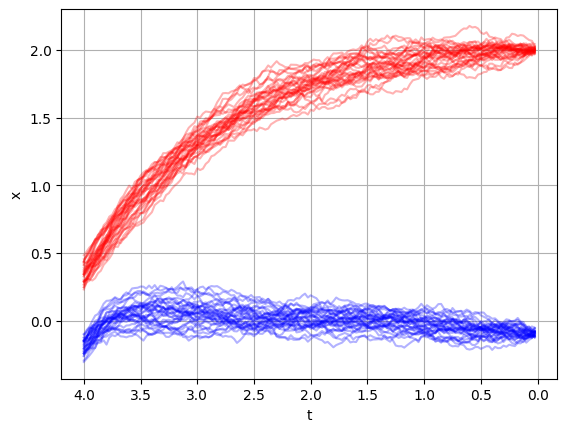

In [17]:
for i in range(32):
    # plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.1)
    # plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.1)
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
# 获取当前y轴的范围
x_min, x_max = plt.xlim()

# 反转y轴范围，实现沿x轴镜像
plt.xlim(x_max, x_min)
plt.grid()

In [18]:
sm_forward_model = ScoreMatchingForwardBridge(
    x0=x0,
    xT=xT,
    proc=cell_proc,
    reverse_score_state=sm_model.state,
    model=ScoreNetSmall(out_dim=dim, hidden_dims=[20, 20, 20, 20]),
    rng_key=jax.random.PRNGKey(42),
    n_batches=32,
    lr=1e-3
)

In [21]:
sm_forward_path, forward_bridge = sm_forward_model.run(n_iters=5000)

Iter 1/5000, Loss: 1871.516845703125
Iter 101/5000, Loss: 1533.53515625
Iter 201/5000, Loss: 902.4906005859375
Iter 301/5000, Loss: 453.3051452636719
Iter 401/5000, Loss: 266.8067321777344
Iter 501/5000, Loss: 212.73101806640625
Iter 601/5000, Loss: 207.66024780273438
Iter 701/5000, Loss: 203.20877075195312
Iter 801/5000, Loss: 198.2615203857422
Iter 901/5000, Loss: 190.7416229248047
Iter 1001/5000, Loss: 189.7900848388672
Iter 1101/5000, Loss: 190.1187744140625
Iter 1201/5000, Loss: 183.1486358642578
Iter 1301/5000, Loss: 189.34169006347656
Iter 1401/5000, Loss: 183.27696228027344
Iter 1501/5000, Loss: 187.6846160888672
Iter 1601/5000, Loss: 181.74185180664062
Iter 1701/5000, Loss: 179.5321807861328
Iter 1801/5000, Loss: 176.248291015625
Iter 1901/5000, Loss: 177.0550079345703
Iter 2001/5000, Loss: 176.34230041503906
Iter 2101/5000, Loss: 172.98341369628906
Iter 2201/5000, Loss: 185.22140502929688
Iter 2301/5000, Loss: 180.70123291015625
Iter 2401/5000, Loss: 187.5955047607422
Iter 25

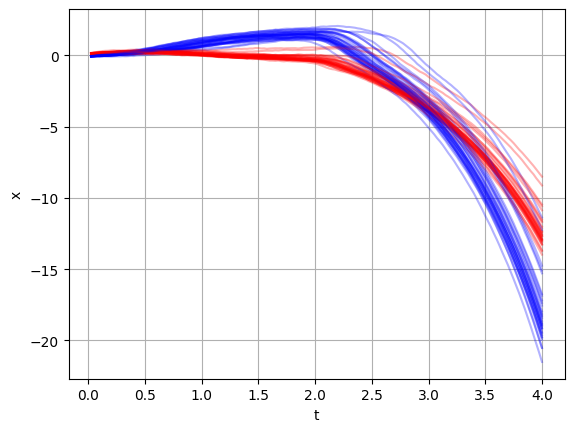

In [22]:
solver = Euler(forward_bridge, wiener_process)
path = solver.solve(x0, dWs=None, rng_key=rng_key, log_likelihood=False, n_batches=32)
for i in range(32):
    plt.plot(path.ts, path.xs[i, :, 0], color='r', alpha=0.3)
    plt.plot(path.ts, path.xs[i, :, 1], color='b', alpha=0.3)
plt.xlabel('t')
plt.ylabel('x')
plt.grid()